In [1]:
import gc
import glob

import geopandas as gpd
import momepy as mm
import numpy as np
import pandas as pd
import shapely
from libpysal.graph import Graph, read_parquet
import datetime

In [2]:
buildings_dir = '/data/uscuni-ulce/processed_data/buildings/'
streets_dir = '/data/uscuni-ulce/processed_data/streets/'
enclosures_dir = '/data/uscuni-ulce/processed_data/enclosures/'
tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
graph_dir = '/data/uscuni-ulce/processed_data/neigh_graphs/'
chars_dir = '/data/uscuni-ulce/processed_data/chars/'

regions_datadir = "/data/uscuni-ulce/"
eubucco_files = glob.glob(regions_datadir + "eubucco_raw/*")

In [3]:
## to build a new conda env
## conda install -c conda-forge momepy umap-learn fast_hdbscan jupyterlab pyarrow matplotlib lonboard folium mapclassify datashader bokeh holoviews dask
# pip install -e . for shapely, momepy, core, geoplanar, fast_hdbscan

In [4]:
osm_ids = ['v0.1-DEU.9.8.13.1_1-194', 'v0.1-DEU.9.8.13.1_1-232',
       'v0.1-DEU.9.8.13.1_1-214', 'v0.1-DEU.9.8.13.1_1-273',
       'v0.1-DEU.9.8.13.1_1-211', 'v0.1-DEU.9.8.13.1_1-188',
       'v0.1-DEU.9.8.13.1_1-192', 'v0.1-DEU.9.8.13.1_1-276',
       'v0.1-DEU.9.8.13.1_1-191', 'v0.1-DEU.9.8.13.1_1-184',
       'v0.1-DEU.9.8.13.1_1-245', 'v0.1-DEU.9.8.13.1_1-275']

In [5]:
region_name = 69300

In [6]:
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "regions_hull.parquet"
    )

In [7]:
region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.loc[region_name].convex_hull

## Streets

In [21]:
from core.generate_streets import process_region_streets

In [22]:
## overture is indexed based on 4326
overture_hull = region_hulls.loc[[region_name], ].to_crs(epsg=4326).convex_hull.iloc[0]

In [23]:
%%time
## processs streets
streets = process_region_streets(overture_hull, region_id)
## save streets
streets.to_parquet(streets_dir + f'streets_{region_id}.parquet')

/home/krasen/urban_taxonomy/core/generate_streets.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]


CPU times: user 3.17 s, sys: 1.62 s, total: 4.79 s
Wall time: 2min 30s


<Axes: >

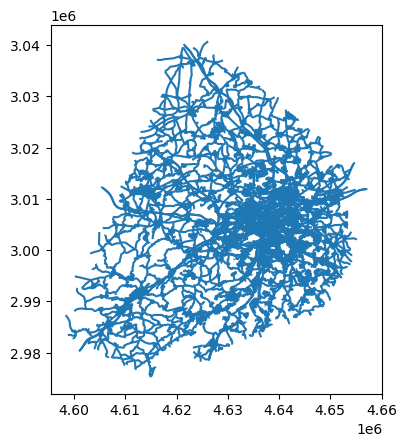

In [25]:
streets.plot()

## Buildings


In [26]:
from core.generate_buildings import read_region_buildings, process_region_buildings

In [27]:
## need to link eubucco building polygons to regions, this will change in the future
building_region_mapping = pd.read_parquet(
    regions_datadir + "regions/" + "id_to_region.parquet", engine="pyarrow"
)
typed_dict = pd.Series(
    np.arange(building_region_mapping["id"].values.shape[0]),
    index=building_region_mapping["id"].values,
)
region_ids = building_region_mapping.groupby("region")["id"].unique()
del building_region_mapping  # its 2/3 gb

In [28]:
%%time

buildings = read_region_buildings(
    typed_dict, region_ids, region_hull, region_id
)

buildings = process_region_buildings(buildings, True, simplification_tolerance=.1, merge_limit=25)



Percent polygons:  0.9999199709227686
Final polygons:  299065 , dropped:  0.05934879566199269
CPU times: user 1min 45s, sys: 1.18 s, total: 1min 46s
Wall time: 1min 45s


In [29]:
buildings.to_parquet(buildings_dir + f"buildings_{region_id}.parquet")

## Enclosures & Tessellation

In [30]:
from core.generate_elements import process_region_elements

In [31]:
%%time
enclosures, tesselations = process_region_elements(buildings_dir, streets_dir, region_id)

---- Processing region:  69300 2024-07-20 12:47:01.519560
Retrying tesselation with less buildings, potentially changing building data.
Dropping 1 buildings due to tesselation problems


NameError: name 'data_dir' is not defined

In [37]:
enclosures.to_parquet(enclosures_dir + f"enclosure_{region_id}.parquet")
print("Processed enclosures")

## save files
tesselations.to_parquet(
    tessellations_dir + f"tessellation_{region_id}.parquet"
)
print("processed tesselations")

Processed enclosures
processed tesselations


In [39]:
# import lonboard
# layer = lonboard.PolygonLayer.from_geopandas(tesselations, opacity=0.15)
# m = lonboard.Map([layer])
# m

In [33]:
# layer = lonboard.PolygonLayer.from_geopandas(enclosures, opacity=0.15)
# m = lonboard.Map([layer])
# m

## Graphs

In [40]:
from core.generate_ngraphs import process_region_graphs

In [41]:
%%time
process_region_graphs(
    region_id,
    graph_dir,
    buildings_dir,
    streets_dir,
    enclosures_dir,
    tessellations_dir,
)

Built tess graph knn=1
Built buildings graph knn=1
Built streets graph knn=1
Built enclosure graph knn=1


/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 304 disconnected components.
  w = W(neighbors, weights, ids, silence_warnings=silence_warnings)


Built nodes graph knn=1
CPU times: user 29.7 s, sys: 513 ms, total: 30.2 s
Wall time: 30.1 s


## Characters

In [42]:
from core.generate_chars import process_single_region_chars

In [43]:
%%time
process_single_region_chars(
    region_id,
    graph_dir,
    buildings_dir,
    streets_dir,
    enclosures_dir,
    tessellations_dir,
    chars_dir
)

2024-07-20 12:54:16.988673 ----Processing ------ 69300
Processing streets
Processing enclosures
Processing buildings


/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/home/krasen/momepy/momepy/functional/_shape.py:576: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(90 - degrees[true_angles]))
/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)
/home/krasen/momepy/momepy/functional/_shape.py:737: RuntimeWarning: Mean of empty slice
  return Series({"mean": np.nanmean(dists), "std": np.nanstd(dists)})
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/krasen/momepy/momepy/functional/_shape.py:890: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(cosine_angle)


Processing tessellation
CPU times: user 5min 58s, sys: 2.54 s, total: 6min 1s
Wall time: 5min 59s


## Generate primary data

In [44]:
tessellation = gpd.read_parquet(chars_dir + f"tessellations_chars_{region_id}.parquet")
buildings = gpd.read_parquet(chars_dir + f"buildings_chars_{region_id}.parquet")
enclosures = gpd.read_parquet(chars_dir + f"enclosures_chars_{region_id}.parquet")
streets = gpd.read_parquet(chars_dir + f"streets_chars_{region_id}.parquet")
nodes = gpd.read_parquet(chars_dir + f"nodes_chars_{region_id}.parquet")


merged = pd.merge(
    tessellation.drop(columns=["geometry"]),
    buildings.drop(columns=["nodeID", "geometry", 'nID']),
    right_index=True,
    left_index=True,
    how="left",
)

merged = merged.merge(
    enclosures.drop(columns="geometry"),
    right_on="eID",
    left_on="enclosure_index",
    how="left",
)

merged = merged.merge(streets.drop(columns="geometry"), on="nID", how="left")
merged = merged.merge(nodes.drop(columns="geometry"), on="nodeID", how="left")

merged = merged.drop(
    columns=[
        "nID",
        "eID",
        "nodeID",
        "mm_len",
        "cdsbool",
        "node_start",
        "node_end",
        "x",
        "y",
        "enclosure_index",
        # "id",
        # "osm_id",
        "index",  ## maybe keep
    ]
)
merged = merged.set_index(tessellation.index)

In [45]:
from core.utils import used_keys

In [46]:
primary = merged[list(used_keys.keys())]
primary.shape

(304554, 62)

In [47]:
primary.to_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

----

In [14]:
# buildings.explore()

In [13]:
region_id = 69300

In [14]:
from core.generate_chars import process_enclosure_chars, process_building_chars, process_tessellation_chars, process_street_chars
# process_street_chars(69300)
# process_enclosure_chars(69300)
# process_building_chars(69300)
process_tessellation_chars(69300)

Processing tessellation


In [ ]:
# tessellation = gpd.read_parquet(
#         data_dir + f"tessellations/tessellation_{69300}.parquet"
#     )

# # import lonboard
# # # layer = lonboard.PolygonLayer.from_geopandas(tessellation, opacity=0.15)
# # # m = lonboard.Map([layer])
# # # m

In [25]:
from core.generate_streets import read_overture_region_streets, rp

In [34]:
streets = read_overture_region_streets(region_hulls.loc[[region_name]].to_crs(epsg=4326).iloc[0].convex_hull, region_id)

In [76]:
orig_streets = streets

In [92]:
approved_roads = ['living_street',
                 'motorway',
                 'motorway_link',
                 'pedestrian',
                 'primary',
                 'primary_link',
                 'residential',
                 'secondary',
                 'secondary_link',
                 'tertiary',
                 'tertiary_link',
                 'trunk',
                 'trunk_link',
                 'unclassified']
streets = orig_streets[orig_streets['class'].isin(approved_roads)]
## drop tunnels
streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]
streets = streets.set_crs(epsg=4326).to_crs(epsg=3035)
streets = streets.sort_values('id')[['id', 'geometry', 'class']].reset_index(drop=True)

/tmp/ipykernel_784467/2213379909.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  streets = streets[~streets.road.str.contains('is_tunnel').fillna(False)]


In [94]:
plotting = streets.reset_index()

In [95]:
import lonboard

In [96]:
layer = lonboard.PathLayer.from_geopandas(plotting, width_min_pixels=1)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [97]:
m = lonboard.Map(layer)
m

Map(layers=[PathLayer(table=pyarrow.Table
index: uint16
id: string
class: string
geometry: list<item: fixed_si…

In [82]:
tunnel = streets.loc[[41318, 41316]]

/tmp/ipykernel_784467/3077578378.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  streets[~streets.road.str.contains('is_tunnel').fillna(False)]


id  \
0      0821e37fffffffff0477ae0e1bed1e9a   
1      0821e37fffffffff047bbe5677a74480   
2      0821e37fffffffff047bfb8fac33b4c9   
3      0821e37fffffffff047fa869f63e10e7   
4      0821e37fffffffff047fff5f666d5099   
...                                 ...   
59854  08e1e354e35110570477ffeef2f023b4   
59855  08e1e354e62e2ac70477ff140f503231   
59856  08e1e354e68de297047befce7622274c   
59857  08e1e354f40a18a7047bffd7edee26e0   
59858  08e1e35503092d070477f3746ebbfcd0   

                                                geometry        class  \
0      LINESTRING (4611749.424 3004369.263, 4611780.6...  residential   
1      LINESTRING (4611714.139 3004739.97, 4611787.46...  residential   
2      LINESTRING (4611567.93 3004432.278, 4611694.70...  residential   
3      LINESTRING (4611467.748 3004340, 4611448.418 3...    secondary   
4      LINESTRING (4611372.18 3006808.012, 4611455.43...     tertiary   
...                                                  ...          ...   
59854  LINESTRING (4645687.693 3003560.862, 4645689.7...     tertiary   
59855  LINESTRING (4643777.747 3005180.047, 4643778.1...     tertiary   
59856  LINESTRING (4642665.336 3005942.733, 4642662.6...    secondary   
59857  LINESTRING (4639107.972 3002845.339, 4639107.8...  residential   
59858  LINESTRING (4628345.163 3023098.153, 4628345.9...  residential   

                                                    road  
0                                                   None  
1                                                   None  
2                                                   None  
3      {"restrictions":{"speed_limits":[{"max_speed":...  
4                                                   None  
...                                                  ...  
59854  {"surface":[{"value":"paved"}],"flags":[{"valu...  
59855  {"surface":[{"value":"paved"}],"restrictions":...  
59856  {"surface":[{"value":"paved"}],"restrictions":...  
59857  {"surface":[{"value":"paved"}],"restrictions":...  
59858                                               None  

[59661 rows x 4 columns]

In [74]:
tess = gpd.read_parquet(f"{chars_dir}tessellations/chars_{region}.parquet")

In [76]:
from libpysal.graph import Graph, read_parquet

In [79]:
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
graph = read_parquet(graph_dir + f"tessellation_graph_{region}_knn1.parquet")

In [100]:
graph2 = Graph.build_fuzzy_contiguity(tess, buffer=.25).assign_self_weight()

In [101]:
graph

<Graph of 315293 nodes and 2203019 nonzero edges indexed by
 [-16229, -16228, -16227, -16226, -16225, ...]>

In [102]:
graph2

<Graph of 315293 nodes and 2235427 nonzero edges indexed by
 [-16229, -16228, -16227, -16226, -16225, ...]>

In [107]:
graph.unique_ids[np.where(graph.cardinalities != graph2.cardinalities)]

Index([-16222, -16221, -16183, -16173, -16154, -16119, -16099, -16083, -16076,
       -16072,
       ...
       298809, 298827, 298837, 298930, 298946, 299010, 299033, 299036, 299040,
       299051],
      dtype='int64', name='focal', length=29468)

In [110]:
# m = tess.loc[graph2[299010].index.values].reset_index().explore()
# m = tess.loc[graph[299010].index.values].reset_index().explore(m=m, color='red')
# m

In [4]:
from core.generate_elements import generate_enclosures
data_dir = "/data/uscuni-ulce/processed_data/"


In [5]:
%%time
buildings = gpd.read_parquet(
    data_dir + f"/buildings/buildings_{region}.parquet"
)
streets = gpd.read_parquet(data_dir + f"/streets/streets_{region}.parquet")
enclosures = generate_enclosures(buildings, streets)

CPU times: user 19.5 s, sys: 559 ms, total: 20.1 s
Wall time: 20 s


In [8]:
import momepy as mm

In [6]:
%%time
buff_buildings = buildings.buffer(105, resolution=2).union_all()

CPU times: user 11.6 s, sys: 3.36 ms, total: 11.6 s
Wall time: 11.6 s


In [9]:
buff_buildings = mm.buffered_limit(buildings, buffer='adaptive')

In [10]:
buffer = gpd.GeoSeries([polygon for polygon in buff_buildings.geoms], crs=buildings.crs)

In [11]:
enclosures = mm.enclosures(streets, limit=buff_buildings, clip=True)

In [12]:
# enclosures.explore()

In [33]:
enclosures = mm.enclosures(streets, limit=buff_buildings, clip=True)


In [37]:
mm.centroid_corner_distance?

Signature:
mm.centroid_corner_distance(
    geometry: geopandas.geodataframe.GeoDataFrame | geopandas.geoseries.GeoSeries,
    eps: float = 10,
    include_interiors: bool = False,
) -> pandas.core.frame.DataFrame
Docstring:
Calculates the centroid-corner distance of each object given its geometry.

As a corner is considered a point where the angle between two consecutive segments
deviates from 180 degrees by more than ``eps``.

Parameters
----------
geometry : GeoDataFrame | GeoSeries
    A GeoDataFrame or GeoSeries containing polygons to analyse.
eps : float, optional
    Deviation from 180 degrees to consider a corner, by default 10
include_interiors : bool, optional
    If True, polygon interiors are included in the calculation. If False, only
    exterior is considered, by default False

Returns
-------
DataFrame
    DataFrame with columns 'mean' and 'std'

Examples
--------
>>> path = momepy.datasets.get_path("bubenec")
>>> buildings = geopandas.read_file(path, layer="buildings")

In [170]:
# buffer.reset_index().explore()

In [160]:
# enclosures.iloc[np.unique(res)].explore()

In [13]:
import shapely

In [14]:
# buffer.reset_index().explore()

In [15]:
buffer.iloc[403]

In [16]:
buffer.iloc[403].exterior

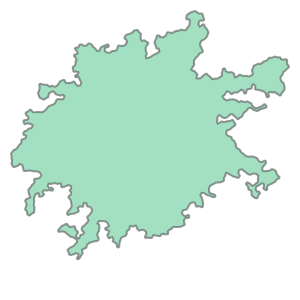

In [17]:
shapely.concave_hull(buffer.iloc[403].exterior, ratio=.02, allow_holes=False)

In [325]:
buffer_no_holes = shapely.polygonize(buffer.exterior.values)
buffer_no_holes = gpd.GeoSeries(buffer_no_holes.geoms, crs=buildings.crs)

In [337]:
inp, res = enclosures.sindex.query(buffer_no_holes.geometry, predicate='intersects')

eID                                           geometry     id
0          7  POLYGON ((4628349.044 2989340.537, 4628430.104...      0
1          8  POLYGON ((4628483.876 2989513.662, 4628470.52 ...      1
2         11  POLYGON ((4628598.701 2989676.165, 4628620.096...      2
3         12  POLYGON ((4628863.193 2989897.119, 4628793.374...      3
4         14  POLYGON ((4628882.821 2989908.356, 4628919.83 ...      4
...      ...                                                ...    ...
15953  25157  POLYGON ((4651173.045 3006357.288, 4651163.362...  15953
15954  25158  POLYGON ((4651774.337 2996866.752, 4651783.234...  15954
15955  25159  POLYGON ((4651963.076 3011990.664, 4651953.299...  15955
15956  25160  POLYGON ((4652587.856 3007923.661, 4652583.712...  15956
15957  25161  POLYGON ((4652299.441 3009561.442, 4652308.959...  15957

[15958 rows x 3 columns]

In [28]:
# enclosures.iloc[np.unique(res)].explore()

In [329]:
has_holes = shapely.get_num_interior_rings(buffer_no_holes.geometry)

In [330]:
with_holes = buffer[has_holes > 0]
with_holes

403    POLYGON ((4627165.472 3002379.907, 4627175.172...
dtype: geometry

In [ ]:
inp, res = enclosures.sindex.query(buffer.geometry, predicate='intersects')